# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В этом проекте предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов на основе данных 500 пользователей «Мегалайна». Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
1. Тариф «Смарт»
 - Ежемесячная плата: 550 рублей
 - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
 - Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля; сообщение: 3 рубля   
 - 1 Гб интернет-трафика: 200 рублей


2. Тариф «Ультра»
 - Ежемесячная плата: 1950 рублей
 - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
 - Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль; сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

__Обратите внимание__: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## 1 Получение общей информации из загруженных файлов

Путь к файлам:
- /datasets/calls.csv
- /datasets/internet.csv
- /datasets/messages.csv
- /datasets/tariffs.csv
- /datasets/users.csv

Подгружаем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
sns.set()
%matplotlib inline

Сохраним датасеты в переменные:

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
for i in (calls, internet, messages, tariffs, users):
    i.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data colu

Посмотрим структуру таблиц:

In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [6]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
tariffs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


__Вывод:__
1. Данные имеют пропуски только в users, возможно, надо будет обработать.
2. В данных необходимо менять тип временных промежутков на datetime.

## 2 Подготовка данных

### 2.1 Таблица calls

In [9]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Приведем тип данных в столбце call_date к типу datetime. Для этого определим функцию, которая может пригодиться в дальнейшем:

In [10]:
def str_to_dt(data, colname):
    data[colname] = pd.to_datetime(data[colname], format='%Y-%m-%d')

In [11]:
# вызовем функцию для изменения типа даты для calls
str_to_dt(calls, 'call_date')

Проверим количество уникальных значений в user_id:

In [12]:
len(calls.user_id.unique())

492

Мини-вывод: 8 человек никому не звонили)

В столбце duration есть значения, равные 0. Скорее всего это ошибка, так как в таблице должны быть данные, отражающие именно звонки, а не недозвоны. Возможно, система неправильно округляла до 0, вместо 1. Такого быть не должно, если факт телефонного звонка был, значит время укажем равное 1.

In [13]:
calls.loc[calls['duration'] == 0, 'duration'] = 1

Округлим значения в calls['duration'] вверх:

In [14]:
calls['duration'] = np.ceil(calls['duration'])

In [15]:
# дробная часть уже не нужна, можно ее не учитывать
calls['duration'] = calls['duration'].astype(int)

### 2.2 Таблица internet

In [16]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Приведем тип данных в столбце session_date к типу datetime:

In [17]:
# вызовем функцию для изменения типа даты для internet
str_to_dt(internet, 'session_date')

Проверим количество уникальных значений в user_id:

In [18]:
len(internet.user_id.unique())

497

Мини-вывод: 3 человека не использовали интернет)

Так как запись о использовании интернет-трафика попала в таблицу заполним единицами значния трафика, равные 0

In [19]:
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

Округлим вверх значения интернет-трафика и отбросим дробную часть:

In [20]:
internet['mb_used'] = np.ceil(internet['mb_used'])
internet['mb_used'] = internet['mb_used'].astype(int)

### 2.3 Таблица messages

In [21]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Приведем тип данных в столбце message_date к типу datetime:

In [22]:
# вызовем функцию для изменения типа даты для messages
str_to_dt(messages, 'message_date')

Проверим количество уникальных значений в user_id:

In [23]:
len(messages.user_id.unique())

426

Мини-вывод: 74 человека не писали сообщения)

### 2.4 Таблица tariffs

In [24]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Ничего менять не будем.

### 2.5 Таблица users

In [25]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


NaN значения в churn_date говорят, что тариф для пользователя еще действовал на момент выгрузки. Посмотрим на количество таких пользователей.

In [26]:
print('Количество пользвателей, для которых действует тариф: {} человек'.format(users[users.churn_date.isna()].shape[0]))
print('Количество пользвателей, для которых не действует тариф: {} человек'.format(users[~users.churn_date.isna()].shape[0]))

Количество пользвателей, для которых действует тариф: 462 человек
Количество пользвателей, для которых не действует тариф: 38 человек


Заменим значения NaN нулями в столбце churn_date:

In [27]:
users['churn_date'] = users['churn_date'].fillna(0)

Приведем даты в churn_date к типу datetime:

In [28]:
def to_dt_apply_func(row):
    if row != 0:
        return pd.to_datetime(row, format='%Y-%m-%d')
    else:
        return 0

In [29]:
users['churn_date'] = users['churn_date'].apply(to_dt_apply_func)

Возможно, эти даты и вовсе ненужны, если надо будет - добавим столбец с двумя значениями: 0 - тариф еще действует, 1 - уже не действует.

Приведем тип данных в столбце reg_date к datetime:

In [30]:
str_to_dt(users, 'reg_date')

#### Выводы

1. Данные обработаны, даты заменены на объекты datetime.
2. В таблице users вместо пропусков подставлены нули.
3. В таблице calls были округлены до целого вверх длительности разговоров и нулевые значения были заменены на единицы.
4. В таблице internet были округлены до целого вверх значения трафика.

## 2.6 Расчеты

_Рассчитаем для каждого пользователя:
количество сделанных звонков и израсходованных минут разговора по месяцам;
количество отправленных сообщений по месяцам;
объем израсходованного интернет-трафика по месяцам;
помесячную выручку с каждого пользователя._

Для начала добавим в наши таблицы столбец с тарифом для каждого абонента. Создадим словарь с соответствием тарифа пользователю.

In [31]:
# создадим словарь, который будет содержать информацию о соответствии тарифа пользователю
tarif_for_user = {}

# напишем функцию для заполнения словаря
def add_tarif_to_user(row):
    tarif_for_user[row[0]] = row[7]
    
# применим функцию
users.apply(add_tarif_to_user, axis=1)
len(tarif_for_user)

500

Получили словарь, в котором сопоставлены user_id и tariff. Добавим колонки с тарифами к calls, internet и messages.

In [32]:
# функция для добавления тарифа
def add_tariff(row):
    return tarif_for_user[row]

for i in (calls, internet, messages):
    i['tariff'] = i['user_id'].apply(add_tariff)

Определим функцию, которая будет добавлять столбец с месяцем в таблицы:

In [33]:
def date_to_month(date, colname):
    date['month'] = date[colname].dt.month

Добавим стобец с номером месяца в наши таблицы:

In [34]:
for i in ((calls, 'call_date'), (internet, 'session_date'), (messages, 'message_date')):
    date_to_month(*i)

Определим функцию для создания сводных таблиц.

In [35]:
def pivot_for_calc(data, values, aggfunc=['sum']):
    return data.pivot_table(index=['user_id', 'tariff', 'month'], values=values, aggfunc=aggfunc)

In [36]:
# расчет звонков по месяцам для каждого пользователя
calls_pivot = pivot_for_calc(calls, 'duration', aggfunc=['sum', 'count'])
calls_pivot.columns = ['Minutes_calls', 'Count_calls']
calls_pivot.head(10)

Minutes_calls  Count_calls
user_id tariff month                            
1000    ultra  5                164           22
               6                187           43
               7                346           47
               8                418           52
               9                478           58
               10               363           57
               11               344           43
               12               341           46
1001    smart  11               444           59
               12               430           63

In [37]:
# расчет сообщений по месяцам для каждого пользователя
messages_pivot = pivot_for_calc(messages, 'id', aggfunc='count')
messages_pivot.columns = ['Count_messages']
messages_pivot.head(10)

Count_messages
user_id tariff month                
1000    ultra  5                  22
               6                  60
               7                  75
               8                  81
               9                  57
               10                 73
               11                 58
               12                 70
1002    smart  6                   4
               7                  11

In [38]:
# расчет интернет-трафика по месяцам для каждого пользователя
internet_pivot = pivot_for_calc(internet, 'mb_used', aggfunc='sum')
internet_pivot.columns = ['Mb_used']
internet_pivot.head(10)

Mb_used
user_id tariff month         
1000    ultra  5         2257
               6        23262
               7        14017
               8        14072
               9        14583
               10       14717
               11       14769
               12        9829
1001    smart  11       18460
               12       14059

Посчитаем выручку с каждого абонента. Для этого надо соединить полученные таблицы. Так как некоторые пользователи не пользовались теми или иными услугами, учтем и это. Будем присоединять наши данные к users.

In [39]:
data_merge = users.merge(calls_pivot.reset_index(), 
                         how='left').merge(internet_pivot.reset_index(), 
                                           how='left').merge(messages_pivot.reset_index(), 
                                                             how='left')
data_merge.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,Minutes_calls,Count_calls,Mb_used,Count_messages
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,164.0,22.0,2257.0,22.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,187.0,43.0,23262.0,60.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,346.0,47.0,14017.0,75.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,418.0,52.0,14072.0,81.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,478.0,58.0,14583.0,57.0


Обработаем nan. Если в ячейке есть nan, значит абонент не пользовался предоставленной связью. Заполним nan нулями.

In [40]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 0 to 3181
Data columns (total 13 columns):
user_id           3182 non-null int64
age               3182 non-null int64
churn_date        3182 non-null object
city              3182 non-null object
first_name        3182 non-null object
last_name         3182 non-null object
reg_date          3182 non-null datetime64[ns]
tariff            3182 non-null object
month             3174 non-null float64
Minutes_calls     3174 non-null float64
Count_calls       3174 non-null float64
Mb_used           3163 non-null float64
Count_messages    2678 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 348.0+ KB


In [41]:
data_merge = data_merge.fillna(0)

Уберем из таблицы данные со значением месяца = 0. У этих записей количество минут, смс и мб также равно 0, они внесут нам искажения в распределения.

In [42]:
data_merge = data_merge[data_merge['month'] != 0]

In [43]:
data_merge.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,Minutes_calls,Count_calls,Mb_used,Count_messages
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,164.0,22.0,2257.0,22.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,187.0,43.0,23262.0,60.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,346.0,47.0,14017.0,75.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,418.0,52.0,14072.0,81.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,478.0,58.0,14583.0,57.0


Вот теперь можно производить расчет выручки по каждому абоненту для каждого месяца.

In [44]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [45]:
""" Рассчитаем помесячную выручку с каждого пользователя 
(вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
остаток умножим на значение из тарифного плана; прибавим абонентскую плату, 
соответствующую тарифному плану)."""

def cash_for_megaline(row):    
    # произведем расчеты выручки для каждого тарифа
    # определим функцию по проверке тарифа и расчета сумм к оплате для каждого абонента
    def check(tariff):  
        # расчет количества минут к оплате
        minutes_for_pay = row[9] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 2]
        if minutes_for_pay < 0:
            minutes_for_pay = 0            
        # расчет количества мегабайт к оплате
        internet_for_pay = np.ceil((row[11] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 1]) / 1024)
        if internet_for_pay < 0:
            internet_for_pay = 0
        # расчет количества сообщений к оплате
        messages_for_pay = row[12] - tariffs[tariffs['tariff_name'] == tariff].iloc[0, 0]
        if messages_for_pay < 0:
            messages_for_pay = 0
        return sum([minutes_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 6], 
                internet_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 4], 
                messages_for_pay * tariffs[tariffs['tariff_name'] == tariff].iloc[0, 5]])
    # создадим переменную, в которую сохраним значения суммы оплаты минут, сообщений и мб сверх тарифа
    result_cash = check(row[7])
    return tariffs[tariffs['tariff_name'] == row[7]].iloc[0, 3] + result_cash

Сохраним значения выручки в столбец revenue.

In [46]:
data_merge['revenue'] = data_merge.apply(cash_for_megaline, axis=1)

Для дальнейших вычислений приведем тип в столбце month к типу int

In [47]:
data_merge['month'] = data_merge['month'].astype(int)

### Выводы:

1. Для каждого пользователя посчитаны по месяцам расходы на звонки (и количество звонков), сообщения и интернет-трафик, из чего была посчитана выручка по месяцам.
2. Были обработаны nan значения после слияния таблиц. 

## 3 Анализ данных

### 3.1 Сколько минут разговора, сообщений и какой объем трафика требуется пользователям каждого тарифа в месяц? Расчет среднего количества, дисперсии и стандартное отклонения.

In [48]:
data_merge.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,Minutes_calls,Count_calls,Mb_used,Count_messages,revenue
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,164.0,22.0,2257.0,22.0,1950.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,187.0,43.0,23262.0,60.0,1950.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,346.0,47.0,14017.0,75.0,1950.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,418.0,52.0,14072.0,81.0,1950.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,478.0,58.0,14583.0,57.0,1950.0
5,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,363.0,57.0,14717.0,73.0,1950.0
6,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,344.0,43.0,14769.0,58.0,1950.0
7,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,341.0,46.0,9829.0,70.0,1950.0
8,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart,11,444.0,59.0,18460.0,0.0,1350.0
9,1001,41,0,Москва,Иван,Ежов,2018-11-01,smart,12,430.0,63.0,14059.0,0.0,550.0


In [49]:
# функция вернет сводную таблицу по месяцам со средними значениями, стандартными отклонениями и дисперсиями для времени 
# разговоров, количества сообщений и интернет-трафика по месяцам
def return_mean_var_std(data, tariff):
    result = data[data['tariff'] == tariff].pivot_table(index='month', 
                                                      values=['Minutes_calls', 'Mb_used', 'Count_messages'],
                                                      aggfunc=['mean', 'std', 'var'])
    result.columns = ['Среднее количество сообщений',
                      'Среднее количество Мб', 
                      'Среднее количество минут разговора',
                      'Стандартное отклонение (сообщения)',
                      'Стандартное отклонение (трафик Мб)',
                      'Стандартное отклонение (звонки)',
                      'Дисперсия (сообщения)',
                      'Дисперсия (трафик Мб)',
                      'Дисперсия (звонки)']
    return result

In [50]:
data_smart = return_mean_var_std(data_merge, 'smart')
data_smart

,Среднее количество сообщений,Среднее количество Мб,Среднее количество минут разговора,Стандартное отклонение (сообщения),Стандартное отклонение (трафик Мб),Стандартное отклонение (звонки),Дисперсия (сообщения),Дисперсия (трафик Мб),Дисперсия (звонки)
month,,,,,,,,,
1,18.235294,8528.588235,209.647059,16.197753,6454.525225,158.869087,262.367201,4.166090e+07,25239.386809
2,24.086207,11617.344828,306.310345,21.750809,6257.131355,195.012749,473.097701,3.915169e+07,38029.972172
3,31.857143,15131.207792,400.532468,26.804710,5837.189240,196.274283,718.492481,3.407278e+07,38523.594327
4,30.741071,13486.080357,377.000000,24.538532,5707.102473,191.102727,602.139559,3.257102e+07,36520.252252
5,33.773050,15832.751773,398.404255,27.036845,5987.642917,190.679274,730.990983,3.585187e+07,36358.585410
6,33.312883,15843.061350,409.196319,28.468636,5811.826881,176.994938,810.463228,3.377733e+07,31327.208135
7,33.751244,15771.398010,419.288557,28.282288,5906.551412,184.005724,799.887811,3.488735e+07,33858.106318
8,33.709402,16664.008547,435.042735,28.994171,5602.267146,189.231942,840.661971,3.138540e+07,35808.727780
9,33.644788,16329.088803,441.779923,28.172181,5213.514041,185.957343,793.671785,2.718073e+07,34580.133549


In [51]:
data_ultra = return_mean_var_std(data_merge, 'ultra')
data_ultra

,Среднее количество сообщений,Среднее количество Мб,Среднее количество минут разговора,Стандартное отклонение (сообщения),Стандартное отклонение (трафик Мб),Стандартное отклонение (звонки),Дисперсия (сообщения),Дисперсия (трафик Мб),Дисперсия (звонки)
month,,,,,,,,,
1,33.777778,13154.666667,440.888889,30.670742,6871.905485,279.972518,940.694444,4.722308e+07,78384.611111
2,21.958333,11788.333333,304.666667,26.773574,10655.243019,304.279858,716.824275,1.135342e+08,92586.231884
3,32.297297,17553.513514,503.081081,41.621886,10963.073083,342.199940,1732.381381,1.201890e+08,117100.798799
4,32.584906,17415.698113,487.811321,37.833865,9439.515563,263.331982,1431.401306,8.910445e+07,69343.732946
5,37.859375,19695.250000,549.468750,41.168206,10167.791106,280.933702,1694.821181,1.033840e+08,78923.745040
6,40.049383,18927.827160,510.666667,41.682101,9371.851255,299.684125,1737.397531,8.783160e+07,89810.575000
7,48.477273,20467.897727,579.397727,46.294901,10207.142643,303.030082,2143.217868,1.041858e+08,91827.230799
8,47.864078,19611.776699,544.941748,45.484332,10575.733985,309.517836,2068.824481,1.118461e+08,95801.290691
9,51.810811,19114.099099,573.594595,45.186988,9564.765466,321.401770,2041.863882,9.148474e+07,103299.097789


## Выводы:

1. Абоненты тарифа 'smart' тратят меньше минут на разговоры и меньше мегабайт интернет-трафика, при этом количество смс, отправляемое абонентами обоих тарифов не сильно отличается.
2. Стандартные отклонения по интернет-трафику и по звонкам для пользователей тарифа 'ultra' больше, чем для 'smart', что говорит о разбросе в использовании тарифных опций большем, чем в 'smart'.

### 3.2 Гистограммы.

Построим гистограммы для звонков, сообщений и использования интернет-трафика для обоих тарифов. Отобразим распределения в одной области построения графика для каждого типа действия.

In [52]:
data_merge.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,Minutes_calls,Count_calls,Mb_used,Count_messages,revenue
0,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,164.0,22.0,2257.0,22.0,1950.0
1,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,187.0,43.0,23262.0,60.0,1950.0
2,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,346.0,47.0,14017.0,75.0,1950.0
3,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,418.0,52.0,14072.0,81.0,1950.0
4,1000,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,478.0,58.0,14583.0,57.0,1950.0


In [53]:
def hist_show(data, tariff, *args):    
    for i in args:
        data[data['tariff'] == tariff][i].plot(kind='hist', title=i, bins=70, alpha=0.7, figsize=(12, 8))
        plt.show()

Построим гистограммы для тарифов smart.

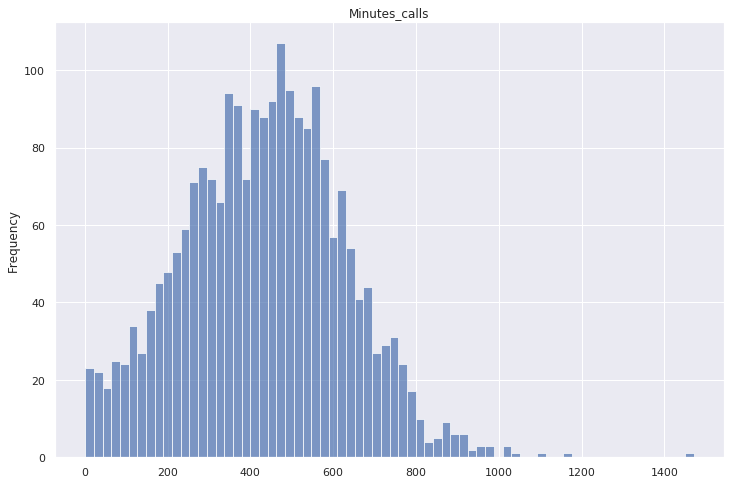

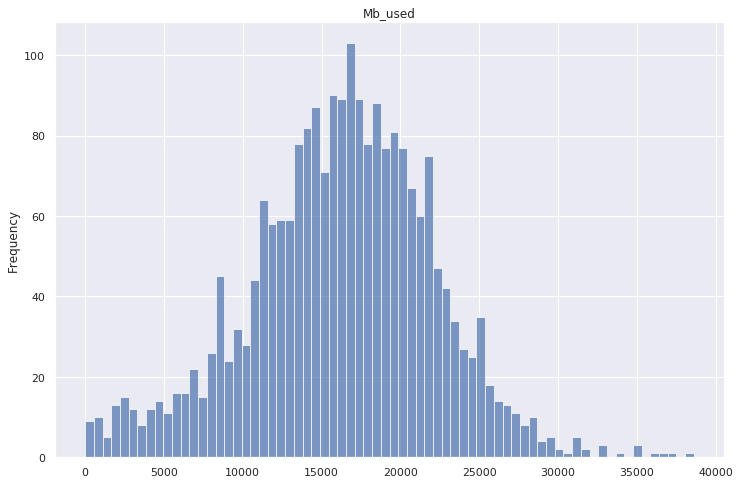

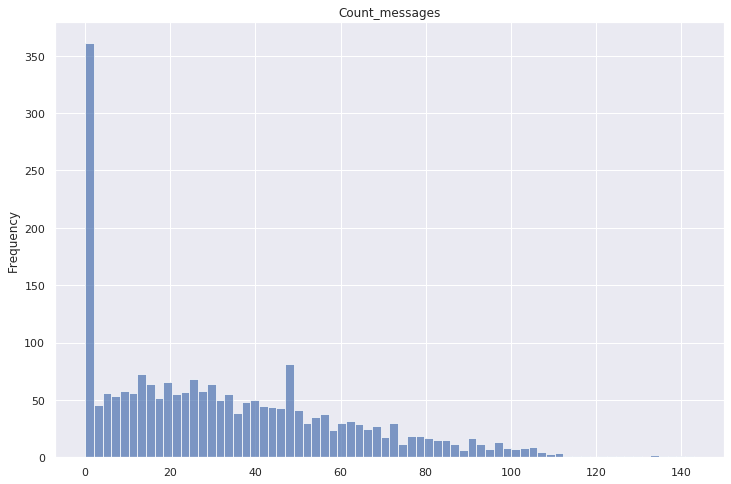

In [54]:
hist_show(data_merge, 'smart', *('Minutes_calls', 'Mb_used', 'Count_messages'))

Посмотрим на распределение сообщений, если отбросить количество сообщений = 0.

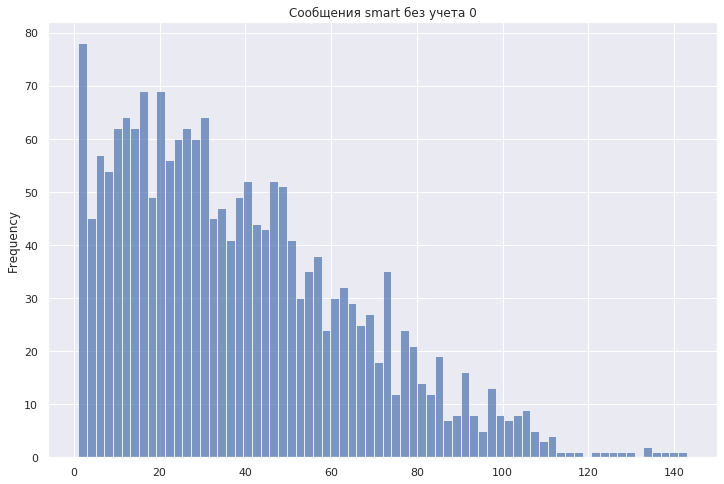

In [55]:
data_merge[(data_merge['tariff'] == 'smart') & 
           (data_merge['Count_messages'] > 0)]['Count_messages'].plot(kind='hist', 
                                                                    bins=70, 
                                                                    alpha=0.7, 
                                                                    figsize=(12, 8), 
                                                                    title='Сообщения smart без учета 0');

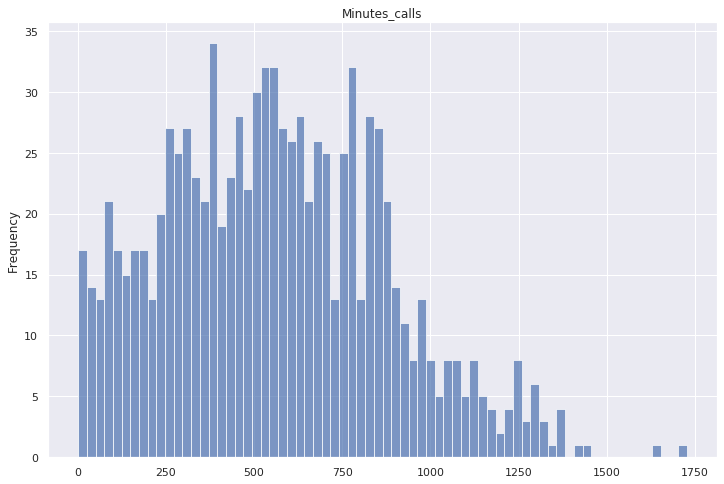

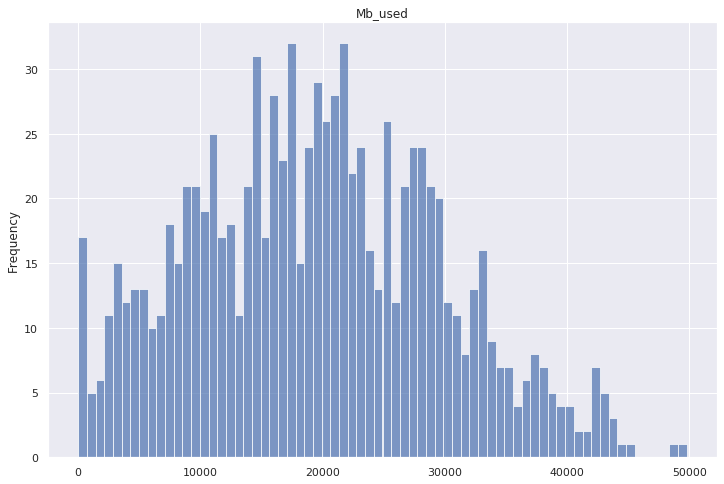

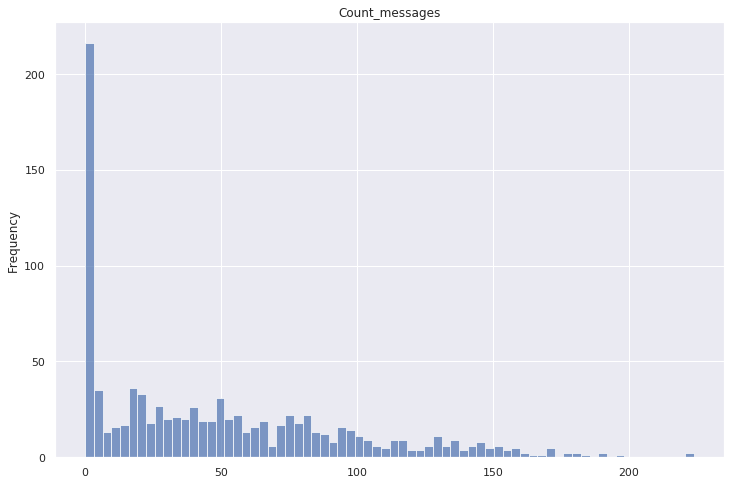

In [56]:
hist_show(data_merge, 'ultra', *('Minutes_calls', 'Mb_used', 'Count_messages'))

Посмотрим на распределение звонков, если отбросить длительность = 1 минуте.

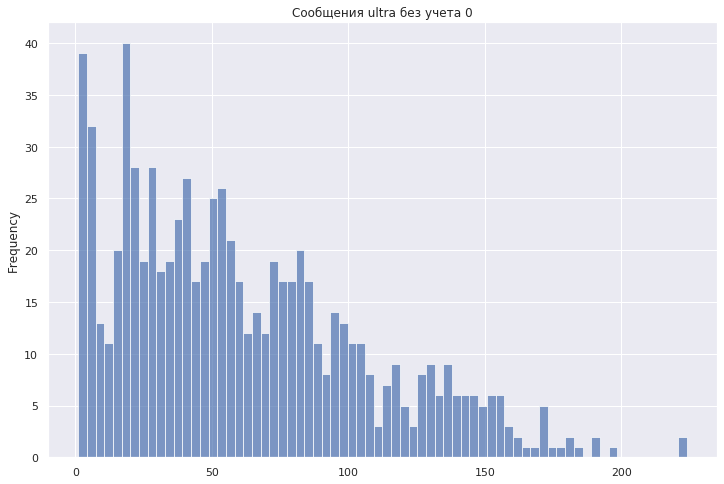

In [57]:
data_merge[(data_merge['tariff'] == 'ultra') & 
           (data_merge['Count_messages'] > 0)]['Count_messages'].plot(kind='hist', 
                                                                    bins=70, 
                                                                    alpha=0.7, 
                                                                    figsize=(12, 8), 
                                                                    title='Сообщения ultra без учета 0');

Добавим график по распределению выручки по каждому из тарифов.

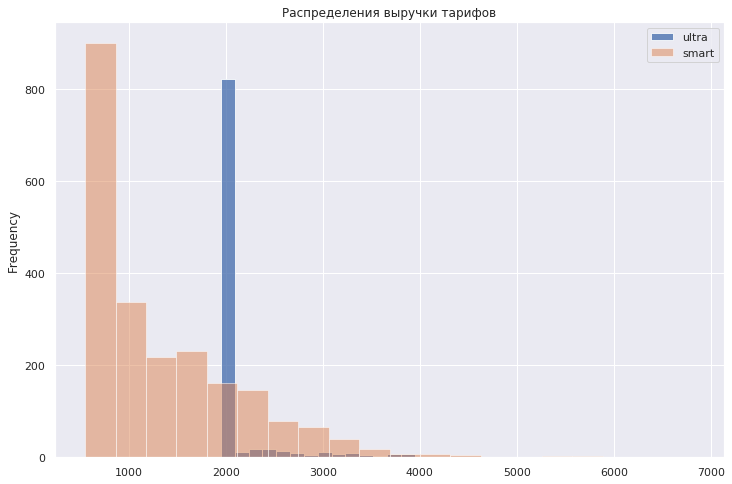

In [79]:
data_merge[(data_merge['tariff'] == 'ultra')]['revenue'].plot(kind='hist', 
                                                                    bins=20, 
                                                                    alpha=0.8, 
                                                                    figsize=(12, 8), 
                                                                    label='ultra')
data_merge[(data_merge['tariff'] == 'smart')]['revenue'].plot(kind='hist', 
                                                                    bins=20, 
                                                                    alpha=0.5, 
                                                                    figsize=(12, 8), 
                                                                    title='Распределения выручки тарифов',
                                                                    label='smart')
plt.legend();

### Выводы:

1. Распределения интернет-трафика являются нормальными с положительными смещениями для обоих тарифов.
2. Распределения для звонков больше похожи на распределения Пуассона.
3. Распределения для сообщений имеют очень большой выброс для количества = 0. Если отбросить эти сообщения, то также получим распределение, которое ближе к распределению Пуассона.
4. Пользователи smart в основном потребляют:
 - от 350 до 550 минут;
 - от 12000 до 22000 мб;
 - до 60 сообщений.
5. Пользователи ultra в основном потребляют:
 - от 250 до 850 минут;
 - от 10000 до 30000 мб;
 - до 100 сообщений.
6. Распределения выручки говорят о том, что пользователи тарифа смарт чаще выходят за границы пакетов, принося прибыль помимо абонентской платы.

## 4 Проверка гипотез

### 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Сформируем нулевую гипотезу - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различна.

Для проверки гипотезы используем scipy.stats.ttest_ind, так как имеем две независимые генеральные совокупности.

In [58]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

In [59]:
result = st.ttest_ind(data_merge[data_merge['tariff'] == 'smart']['revenue'], 
                      data_merge[data_merge['tariff'] == 'ultra']['revenue'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.740263690322774e-144
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность равенства выручки обоих тарифов стремится к нулю, следовательно нулевая гипотеза не верна - средняя выручка пользователей тарифов «Ультра» и «Смарт» различна.

### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформируем нулевую гипотезу - средняя выручка пользователей из Москвы и пользователей из других регионов равна.

Альтернативная гипотеза - средняя выручка пользователей из Москвы и пользователей из других регионов различны.

Для проверки гипотезы снова используем scipy.stats.ttest_ind, так как имеем две независимые генеральные совокупности.

In [60]:
result = st.ttest_ind(data_merge.query('city == "Москва"')['revenue'], 
                      data_merge.query('city != "Москва"')['revenue'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.49838061357698993
Не получилось отвергнуть нулевую гипотезу


Полученные результаты говорят о том, что, хотя выручка и различна, но с 50 % вероятностью можно получить различие случайно. Это очень большая вероятность. Нулевая гипотеза не может быть отвергнута.

### 4.3 Какой тариф лучше?

Для ответа на вопрос, какой тариф лучше, сформулируем нулевую гипотезу - тариф "Смарт" лучше тарифа "Ультра". Или по другому - среднее значение выручки тарифа "Смарт" больше средней выручки "Ультра".

Используем st.ttest_1samp, так как нужно расчитать p-value одной выборки и сравнить его с ожидаемым значением.

In [61]:
# средняя выручка тарифа Смарт
mean_smart = data_merge[data_merge['tariff'] == 'smart']['revenue'].mean()

alpha = 0.05

ultra = data_merge[data_merge['tariff'] == 'ultra']['revenue']

results = st.ttest_1samp(ultra, mean_smart)


# тест односторонний: p-value будет в два раза меньше
print('p-значение: ', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только если выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (data_merge[data_merge['tariff'] == 'ultra']['revenue'].mean() > mean_smart):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0
Отвергаем нулевую гипотезу


p-value = 0 (очень мало видать...). Тариф Ультра лучше.

## Общий вывод: 

Для ответа на вопросы по средней выручке пользователей разных тарифов или из разных городов предварительно была произведена обработка исходных датасетов, в каждую таблицу добавлены сведения о тарифах для каждого пользователя.

Исправлены ошибки в длительности звонков, а также округлены в большую сторону значения минут разговора и мегабайт интернет-трафика.

Для каждого пользователя расчитано:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячная выручка с каждого пользователя.

Расчитанные данные добавлены в одну общую сводную таблицу, в которой все расходы по тарифам сгруппированы по месяцам для каждого пользователя. Были обработаны nan значения.

Расчитано, сколько минут разговора, сообщений и какой объем трафика требуется пользователям каждого тарифа в месяц, а также произведен расчет среднего количества, дисперсии и стандартное отклонения. Результаты расчета сведены в общую таблицу.

Построены гистограммы, проанализированы распределения и сделаны выводы по использованию звонками, сообщениями и интернет-трафиком пользователями каждого тарифа.

В заключительной части сформулированы и проверены гипотезы о различии выручки в зависимости от тарифа и от города пользователей. Приведены обоснования полученых результатов. Сделан вывод из расчета t-критерия Стьюдента для среднего одной выборки, что тариф Ультра лучше.